In [69]:
# Begin Project 2
# Melvin Molina :)
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

<h1>Part 1: Wrangling </h1><br>
<b>Problem 1</b>: <br>Using SQL compute a relation containing the total payroll and winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination). You should include other columns that will help when performing EDA later on (e.g., franchise ids, number of wins, number of games).

After querying from the salaries and teams table, I dealt with missing data by making sure to only combine data when both year and teamID were the same. This led to the missing data to not be passed over into the main list.

In [61]:
# use SQL to get data from the Salaries table
salary_query = "SELECT teamID, yearID, sum(salary) as total_payroll FROM Salaries \
WHERE yearID >= 1990 GROUP BY teamID, yearID ORDER BY teamID"

# use SQL to get data from the Winrate table
winrate_query = "SELECT teamID, yearID, W as wins, G as games, \
CAST(W AS FLOAT)*100 / (G) as win_percentage, franchID FROM teams \
WHERE yearID >= 1990 GROUP BY teamID, yearID ORDER BY teamID"

# Create the dataframes used for the merge
team_salaries = pd.read_sql(salary_query, conn)
team_win_rate = pd.read_sql(winrate_query, conn)

# merge the two data frames to get the data we are looking for.
wrangle = team_salaries.merge(team_win_rate, how = "inner", \
                           left_on = ["teamID", "yearID"], right_on = ["teamID", "yearID"])

wrangle

,teamID,yearID,total_payroll,wins,games,win_percentage,franchID
0,ANA,1997,31135472.0,84,162,51.851852,ANA
1,ANA,1998,41281000.0,85,162,52.469136,ANA
2,ANA,1999,55388166.0,70,162,43.209877,ANA
3,ANA,2000,51464167.0,82,162,50.617284,ANA
4,ANA,2001,47535167.0,75,162,46.296296,ANA
...,...,...,...,...,...,...,...
723,WAS,2010,61400000.0,69,162,42.592593,WSN
724,WAS,2011,63856928.0,80,161,49.689441,WSN
725,WAS,2012,80855143.0,98,162,60.493827,WSN
726,WAS,2013,113703270.0,86,162,53.086420,WSN


<h2>Part 2: Exploratory Data Analysis </h2>

Problem 2: Write code to produce plots that illustrate the distribution of payrolls across teams conditioned on time (from 1990-2014). If a flat line existst that shows the team didn't play during that certain period.

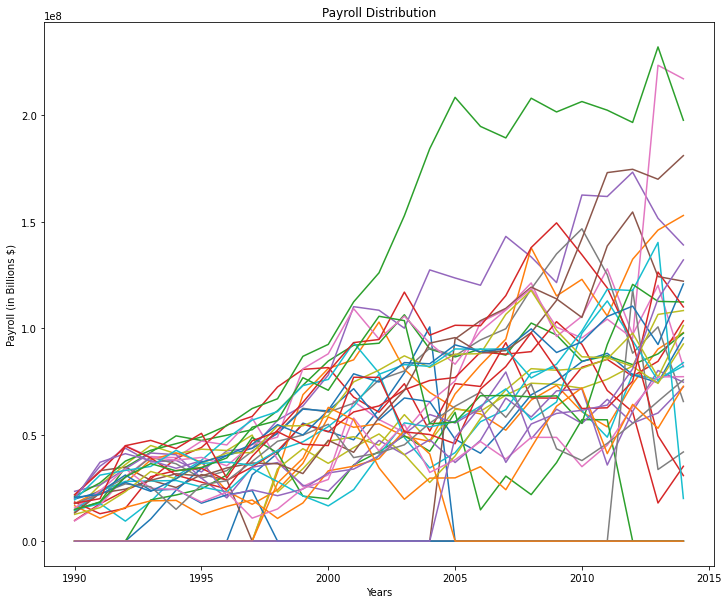

In [62]:
# create a list with all the team names
teams = np.unique(wrangle.iloc[:,0].values)

# construct a data frame with the team names specific to the years 1990 to 2014
years = np.arange(1990, 2015)

# data frame is constructed
yearstbl = pd.DataFrame(columns = ['yearID'], data = years)

# this hash will contain the data to then graph
dataPoints = {}

# Creating the plot and labeling the axis and title
plt.figure(figsize = (12, 10))

plt.title("Payroll Distribution")

plt.xlabel("Years")

plt.ylabel("Payroll (in Billions $)")

# iterating the team list to find the team data
for t in teams:
    
    # getting the team data and grouping it by team
    plot_table = wrangle.drop(wrangle[t != wrangle['teamID']].index)
    relation = wrangle[['yearID','teamID','total_payroll']].groupby(['teamID']).get_group(t)

    # Insert the data into the hash and plot on the graph
    dataPoints[t] = yearstbl.merge(relation, how = 'left', left_on = ['yearID'], right_on = ['yearID'])
    plt.plot(dataPoints[t]['yearID'], dataPoints[t]['total_payroll'].fillna(value=0))

plt.show()


<h2>Question 1 </h2>

Over time there's certainly an increase in payroll for every team. Spanning from .1 to .5 in about 1993, while in 2014 spanning from .3 all the way up to apprx 2.2, in billions of dollars. Although the increase to the Mean in payroll in more recent years has become less than before. the range is very large from 1990 to 2015.

<h1>Problem 3</h1><br>
Write code to produce plots that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specficially.

Below I show the mean, the increase in mean over time has diminished since 2010-2015. Whereas from 1995-2000 the increase in mean was larger.

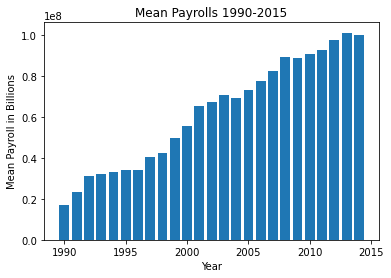

In [63]:

# joining the two tables from above
avgtable = wrangle[['yearID','total_payroll']]

# transofmring the tables into the mean values
avgpayroll = (avgtable.groupby('yearID')).mean()

# creating the plot
plt.title("Mean Payrolls 1990-2015")
plt.xlabel("Year")
plt.ylabel("Mean Payroll in Billions")
plt.bar(avgpayroll.index, avgpayroll['total_payroll'])
plt.show()

<h1> Correlation between payroll and winning percentage </h1>

<h1>Problem 4</h1>
Write code to discretize year into five time periods (you can use pandas.cut to accomplish this) and then make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. You could add a regression line (using, e.g., NumPy's polyfit) in each scatter plot to ease interpretation.

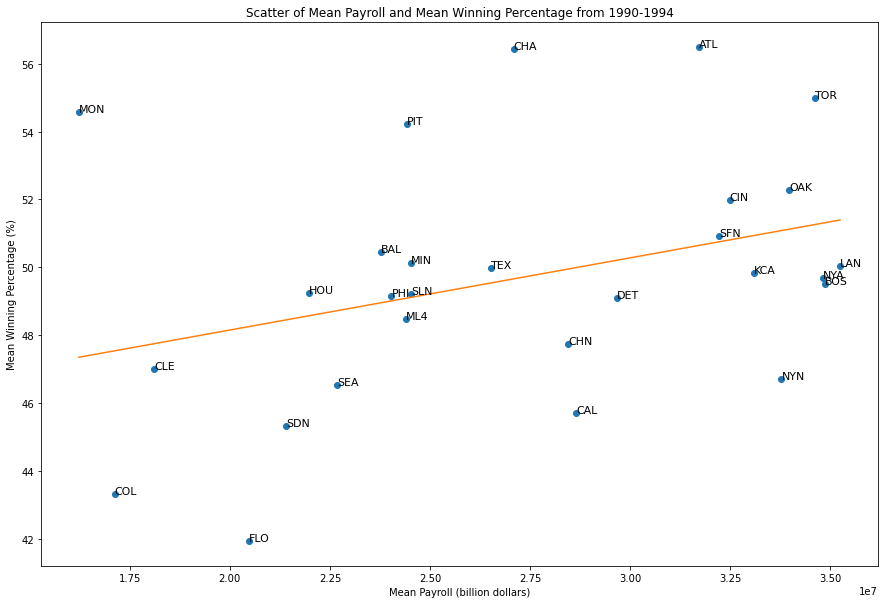

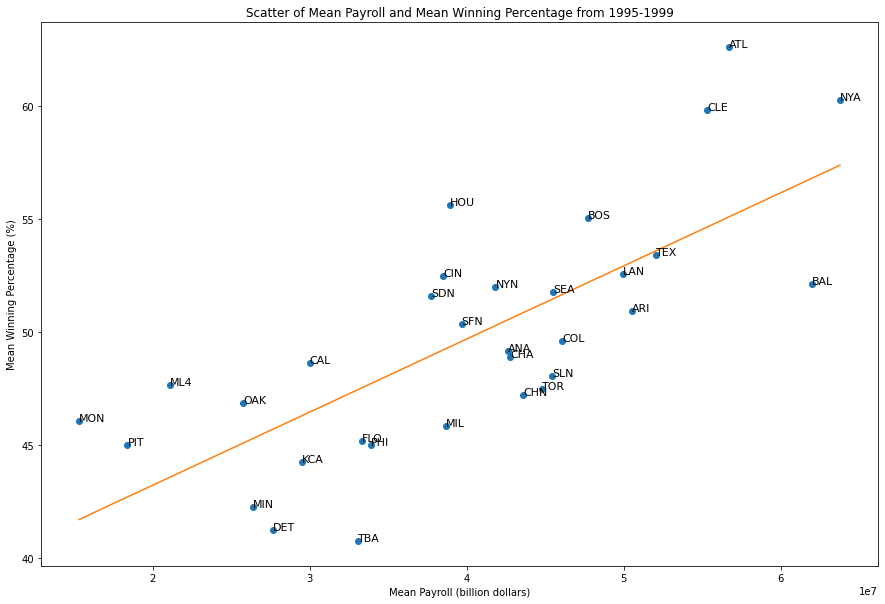

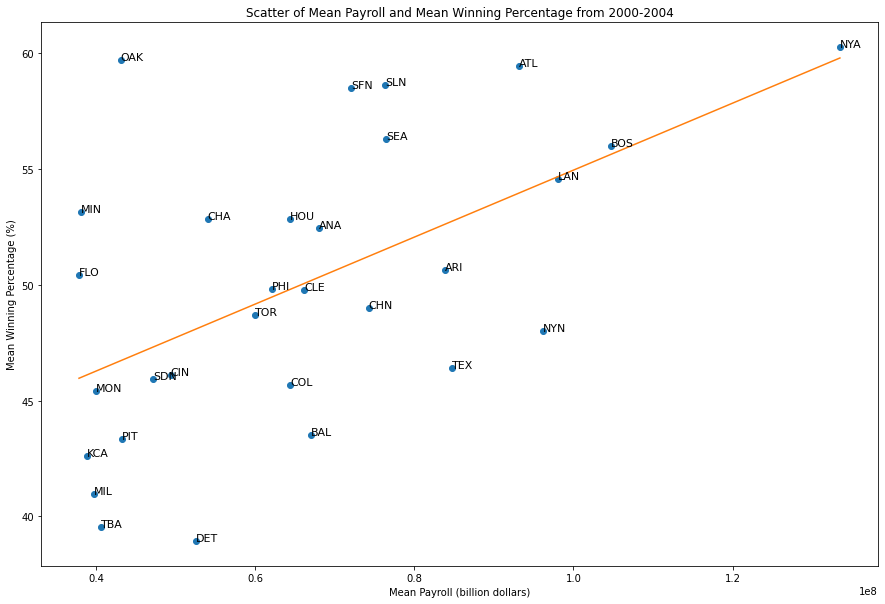

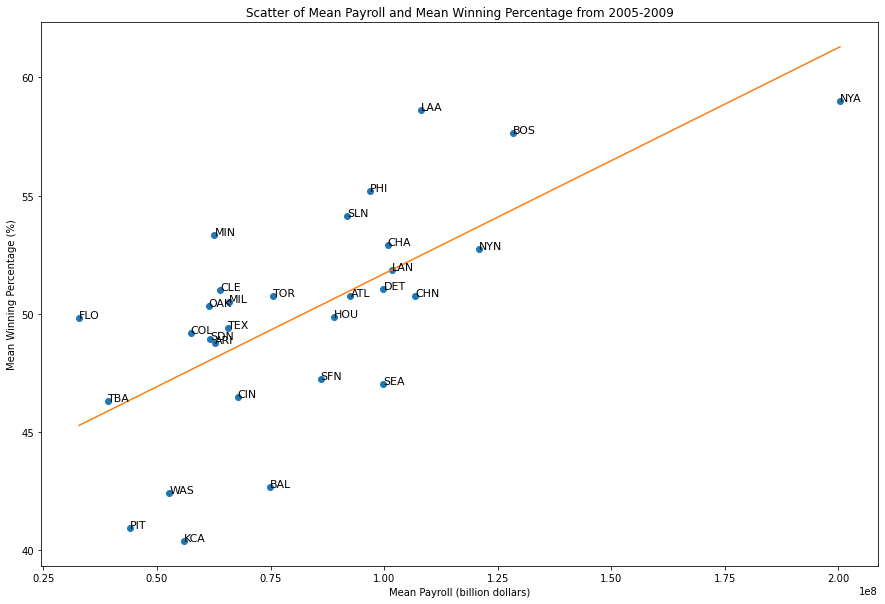

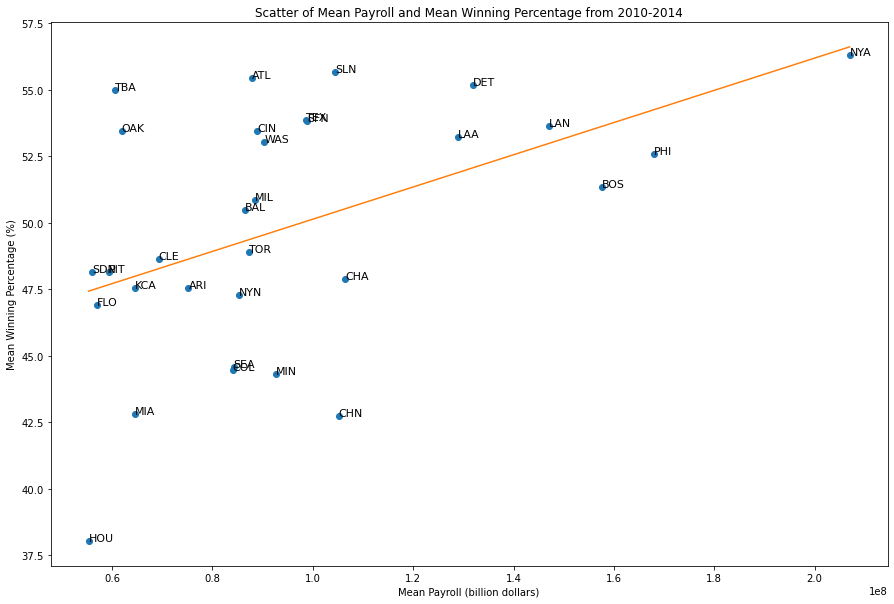

In [64]:
# placing the team names into the array teams
teams = np.unique(wrangle.iloc[:,0].values)

# Creating a data frame to then place the data, this data frame contains the years
years = np.arange(1990, 2015)

yearstbl = pd.DataFrame(columns = ['yearID'], data = years)


# merge the data from yearstbl and table 
table = wrangle[['yearID','teamID','total_payroll','wins','games']]

table = yearstbl.merge(table, how = "left", left_on = ['yearID'], right_on = ['yearID'])

# adding the bins/buckets per time period
periods = ['1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']

table['time_period'] = pd.cut(table['yearID'], right = False, bins = 5, labels = periods)


# this will create a graph for every period of time
for p in periods:
    
    # getting current time data
    compare_table = table.drop(table[p != table['time_period']].index)
    
    
    # calculate the mean of payroll per team within the said time period
    mean_payroll = (compare_table.groupby(['teamID']))['total_payroll'].mean()

    # calculate the mean win rate per team within the said time period
    compare_table['win_rate'] = (100*compare_table['wins']) / (compare_table['games'])
    
    mean_win = (compare_table.groupby(['teamID']))['win_rate'].mean()
    
    #  parsing from series to a dataframe object
    payroll = mean_payroll.to_frame()
    
    win = mean_win.to_frame()
    
    
    # Shifting around the data frames and finalizing the organization of by teamID
    payroll['teamID'] = payroll.index
    win['teamID'] = win.index
    
    # merging the tables 
    final_table = payroll.merge(win, left_on = payroll['teamID'], right_on = win['teamID'])
    # the tables merged and have extra columns, and have renamed some as well.
    final_table.rename(columns={"teamID_x": "teamID"})
    del final_table["teamID_y"]
    del final_table["key_0"]
    
    # adjusting the columns to what we expect
    final_table.columns = ['mean_payroll', 'teamID', 'mean_win_rate']
    
    # retrieve values for x-axis
    x_data = final_table['mean_payroll'].values
    # retrieve values for y-axis
    y_data = final_table['mean_win_rate'].values
    
    # adding reression line and data points
    z = np.polyfit(x = x_data, y = y_data, deg=1)
    f = np.poly1d(z)
    x_new = np.linspace(x_data.min(), x_data.max(), 100)
    y_new = f(x_new)
    plt.figure(figsize=(15,10))
    
    # plotting the graph
    plt.plot(x_data, y_data,'o', x_new, y_new)
    
    # adding the team name to every node of data
    for j, txt in enumerate(final_table['teamID']):
        plt.annotate(txt, (x_data[j], y_data[j]), size = 11)
    
    # graph details
    plt.title("Scatter of Mean Payroll and Mean Winning Percentage from " + p)
    
    plt.xlabel("Mean Payroll (billion dollars)")
    
    plt.ylabel("Mean Winning Percentage (%)")
    
    plt.show()

<h1>Question 2</h1><br>
Across the board it's clearly visible that there's a correlation between the higher mean payroll and a higher win percentage. Although in recent years the threshold of about 1.4 billion in the 2010-2014 period, anything past that is not as efficient. The line of regression shows the uniformity growing within the more recent years. Visibly, the Los Angeles Angels (LAA) have been good with their spending efficiency. Although they enter the graph in the last two periods, their spending efficiency across those two graphs has been above average. Being above the line of regression and maintaining a 52%+ win ratio across ten years. For the Oakland A's (OAK) their spending efficiency was initially slightly above average, but starting since the 2000-2004 period they became unprecedentedly spending efficient. Their mean payroll in the 2000-2004 period was about .45 billion while holding an almost 60% win ratio. Ever since, they've maintainted a mean payroll of less than .75 Billion while having a 52%+ win ratio. The  line of regression helps interpret the data by helping show teams who are above the line of regression are efficient spenders, while teams that are under are not spending their money efficiently.

<h1>Part 3: Data transformations</h1>
<b>Problem 5</b><br>
Create a new variable in your dataset that standardizes payroll conditioned on year.

In [65]:
# Getting the mean and std deviation for each year 
avg_payroll = (table.groupby(['yearID']))['total_payroll'].mean()

std_payroll = (table.groupby(['yearID']))['total_payroll'].std()


# changing from series into data frames
avg_payroll = avg_payroll.to_frame()

s_payroll = std_payroll.to_frame()


# Organizing the index of the dataframes
avg_payroll['yearID'] = avg_payroll.index
s_payroll['yearID'] = std_payroll.index

# merging avg payroll and s_payroll to get the average and std dev of payroll in every year
avg_s = avg_payroll.merge(s_payroll, left_on = avg_payroll['yearID'], right_on = s_payroll['yearID'])

# Reorganizing the columns in avg_s dataframe as a result of the merge
avg_s.rename(columns={"yearID_x": "yearID", "total_payroll_x" : "avg_payroll", "total_payroll_y" : "s_payroll"})
del avg_s["yearID_y"]
del avg_s["key_0"]

# finalizing the organizaion of avg_s dataframe
avg_s.columns = ['avg_payroll', 'yearID', 's_payroll']


#noting the columns needed to calculate the payroll deviation per year
payroll = table[['yearID', 'teamID', 'total_payroll', 'time_period']].copy()

# this will begin the iteration in payroll and avg_s
payroll['std_payroll'] = 0.0


for i, row1 in payroll.iterrows():
    
    for j, row2 in avg_s.iterrows():
        
        
        # beginning the calculation if the years match
        if (row1['yearID'] == row2['yearID']):
            
            # using the formula to get the standardized payroll and placing it into the table payroll
            a = avg_s['avg_payroll'][j]
            s = avg_s['s_payroll'][j]
            payroll.at[i, 'std_payroll'] = (payroll['total_payroll'][i] - a) / s

# Sorting the table by year and tidying the data
payroll.sort_values(by = ['yearID', 'teamID'], inplace = True)
payroll = payroll.reset_index().drop('index', 1)
payroll = payroll[['yearID', 'teamID', 'total_payroll', 'std_payroll', 'time_period']]
payroll

,yearID,teamID,total_payroll,std_payroll,time_period
0,1990,ATL,14555501.0,-0.667275,1990-1994
1,1990,BAL,9680084.0,-1.959861,1990-1994
2,1990,BOS,20558333.0,0.924213,1990-1994
3,1990,CAL,21720000.0,1.232198,1990-1994
4,1990,CHA,9491500.0,-2.009859,1990-1994
...,...,...,...,...,...
723,2014,SLN,120693000.0,0.457126,2010-2014
724,2014,TBA,72689100.0,-0.593171,2010-2014
725,2014,TEX,112255059.0,0.272509,2010-2014
726,2014,TOR,109920100.0,0.221422,2010-2014


<h1>Problem 6</h1>
Repeat the same plots as Problem 4, but use this new standardized payroll variable.

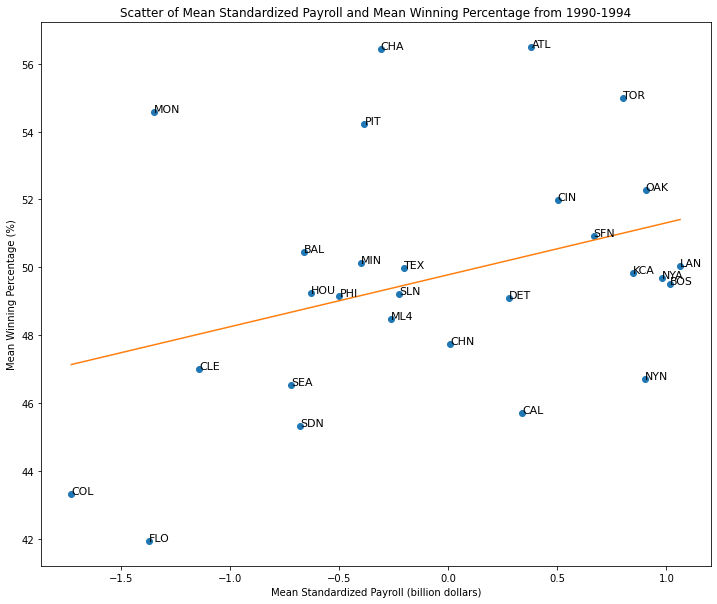

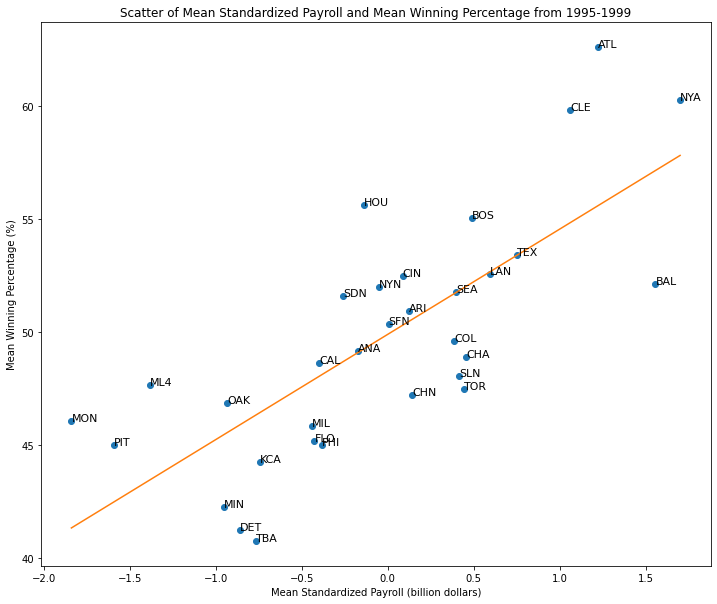

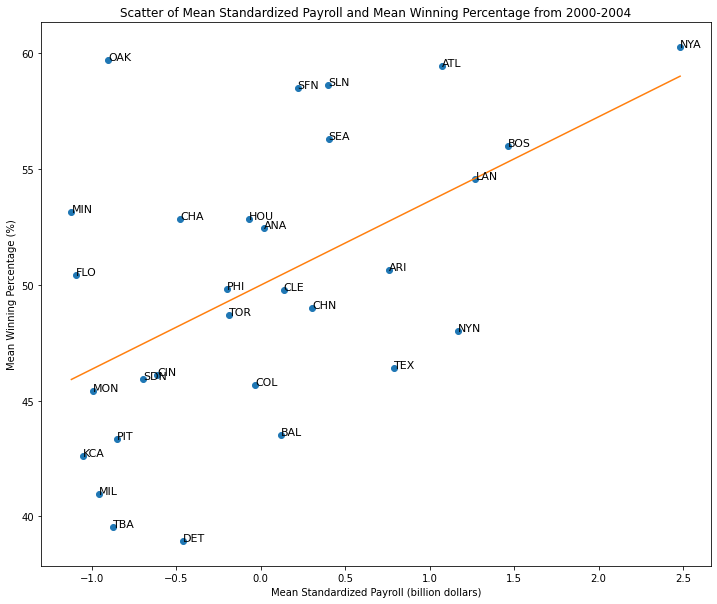

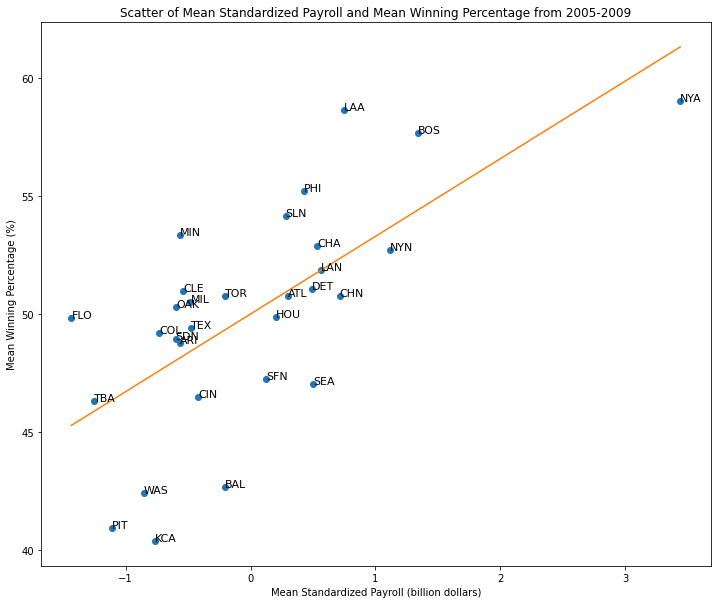

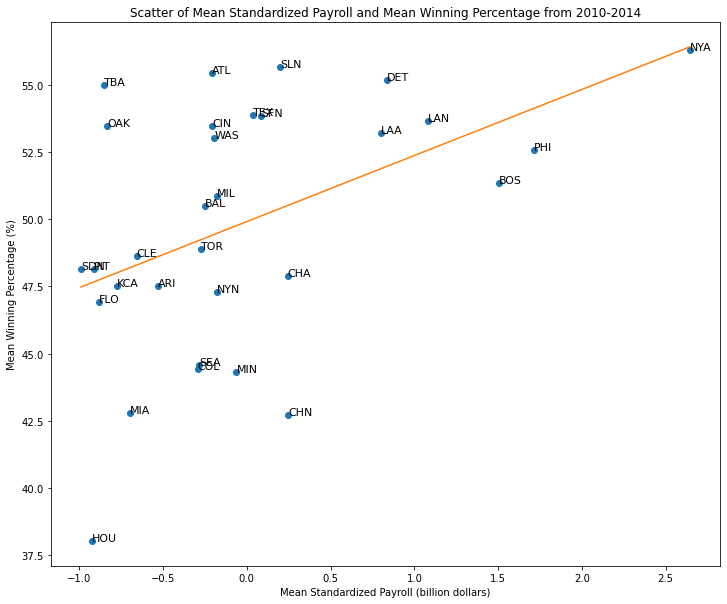

In [66]:
# retrieving the std_payroll to work on
table['std_payroll'] = payroll['std_payroll'].values

# creating a graph for every seperate time period
for p in periods:
    
    # getting the data from the previous data stored for the time period we are on
    compare_table = table.drop(table[p != table['time_period']].index)
    mean_std = (compare_table.groupby(['teamID']))['std_payroll'].mean()

    # calculating the avg win rate for all the teams during this iteration
    compare_table['win_rate'] = (100*compare_table['wins']) / (compare_table['games'])
    
    mean_win = (compare_table.groupby(['teamID']))['win_rate'].mean()
    
    # Parsing from series into dataframes
    std = mean_std.to_frame()
    win = mean_win.to_frame()
    
    #  organizing the win columns and grouping by teamID
    win['teamID'] = win.index
    win.columns = ['mean_win_rate', 'teamID']
    
    # organize the std columns by teamID as well
    std['teamID'] = std.index
    std.columns = ['mean_std_pay', 'teamID']
    
    # finishing my merging into a final table to then display
    final_table = std.merge(win, left_on = std['teamID'], right_on = win['teamID'])
    
    # organizing the final table because of the result of the merge.
    final_table.rename(columns={"teamID_x": "teamID"})
    del final_table["key_0"]
    del final_table["teamID_y"]
    
    # finalizing the dataframe to accurate columns
    final_table.columns=['mean_std_pay', 'teamID', 'mean_win_rate']
    
    # beginning to create the plot
    x_vals = final_table['mean_std_pay'].values
    y_vals = final_table['mean_win_rate'].values

    # line of regression
    z = np.polyfit(x = x_vals, y = y_vals, deg=1)
    f = np.poly1d(z)
    
    x_new = np.linspace(x_vals.min(), x_vals.max(), 100)
    
    y_new = f(x_new)
    
    # graphing the plot
    plt.figure(figsize=(12,10))
    plt.plot(x_vals, y_vals,'o', x_new, y_new)
    
    # Adding team names to each data point.
    for i, txt in enumerate(final_table['teamID']):
        plt.annotate(txt, (x_vals[i], y_vals[i]), size = 11)
    
    # adding the graph titles and axis names
    plt.title("Scatter of Mean Standardized Payroll and Mean Winning Percentage from " + p)
    plt.xlabel("Mean Standardized Payroll (billion dollars)")
    plt.ylabel("Mean Winning Percentage (%)")
    plt.show()

<h1>Question 3</h1><br>
Overall the plots in problem 4 and problem 6 are similar with the increasing trend in every time period. The variable effects the x-axis, changing it to scaling with the previous graphs mean payroll. This allows us to better interpret the relationship across time periods. Whereas the plot in problem 4 was making it easier to recognize the mean payrolls, but it didn't allow for a cross time period analysis as easy as the x-axis change on problem 6 does. This plot allows us to see how many standard deviations away from the mean payroll each team is in every time period. When a team is positive that means they are above the mean payroll, when a team is negative they lie below the mean payroll. The efficiency of payroll is more easily detectable in this graph. For highest amount of efficiency you'd want the team to be placed in the top left corner of the graph. That would be interpretted as spending less for a higher win ratio, which means a better spending efficiency.

<h1>Problem 7</h1>
Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship.

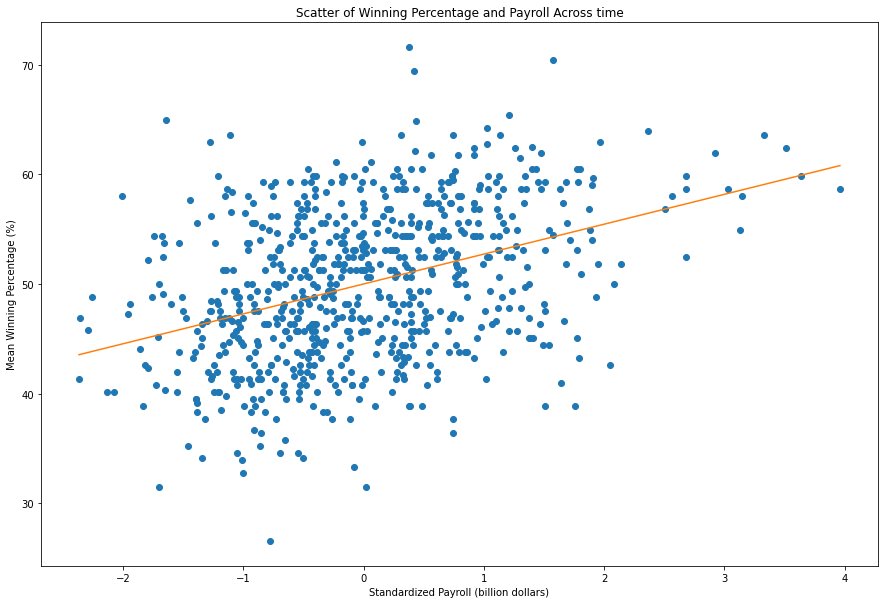

In [67]:
# copying the payroll table to calculate this new plot
std = payroll.copy()

# Getting win percent, year and teamID from the first table created 
win_rate = pd.DataFrame(columns = ['yearID', 'win_percentage'])

win_rate['yearID'] = wrangle['yearID']

win_rate['teamID'] = wrangle['teamID']

win_rate['win_percentage'] = wrangle['win_percentage']


# merging tables to have our calculated payroll data and the win percentage in one table
std_win = std.merge(win_rate, how = 'inner', left_on = ['yearID', 'teamID'], right_on = ['yearID', 'teamID'])

# this will contain the payroll data in x axis values
x_vals = std_win['std_payroll'].values

# this will contain the win percentage data in y axis values
y_vals = std_win['win_percentage'].values

# constructing the plot and line of regression
ply = np.polyfit(x = x_vals, y = y_vals, deg=1)
fit = np.poly1d(ply)

x_new = np.linspace(x_vals.min(), x_vals.max(), 100)
y_new = fit(x_new)

plt.figure(figsize=(15,10))
plt.plot(x_vals, y_vals,'o', x_new, y_new)
    
# adding the plots title and axis labels
plt.title("Scatter of Winning Percentage and Payroll Across time")
plt.xlabel("Standardized Payroll (billion dollars)")
plt.ylabel("Mean Winning Percentage (%)")
plt.show()

<h1>Problem 8</h1><br>
Create a new field to compute each team's spending effiency. for team i in year j, where expected_win_pct is given above.

Make a line plot with year on the x-axis and efficiency on the y-axis. A good set of teams to plot are Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay (teamIDs OAK, BOS, NYA, ATL, TBA).

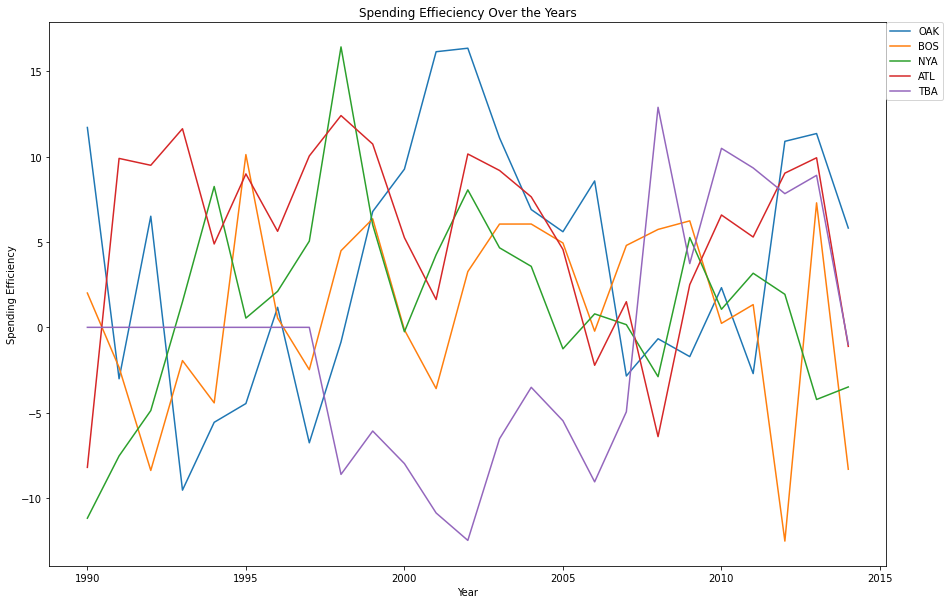

In [68]:
# using given formula to get the spending efficiency
std_win['expected_win'] = std_win['std_payroll'] * 2.5 + 50

std_win['efficiency'] = std_win['win_percentage'] - std_win['expected_win']

# constructing the dataframe to hold the teams data
years = np.arange(1990, 2015)
yearstbl = pd.DataFrame(columns = ['yearID'], data = years)

# construct a hash to place the teams we will be working with's data
teams = ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']
d = {}

# construct the plot
plt.figure(figsize=(15,10))
plt.title("Spending Effieciency Over the Years")
plt.xlabel("Year")
plt.ylabel("Spending Efficiency")

# iterating across the team names we will be working with
for team in teams:
    
    # Getting the data from the team we are on 
    plot_table = std_win.drop(std_win[team != std_win['teamID']].index)
    relation = std_win[['yearID','teamID','efficiency']].groupby(['teamID']).get_group(team)

    # connecting the data we calcalated with the years by merging
    d[team] = yearstbl.merge(relation, how = 'left', left_on = ['yearID'], right_on = ['yearID'])
    
    # plotting the team line graph 
    plt.plot(d[team]['yearID'], d[team]['efficiency'].fillna(value = 0), label = team)
    # labeling the key 
    plt.legend(bbox_to_anchor = (1.0, 1), loc = 2, borderaxespad = 0.)
    
plt.show()

<h1>Question 4</h1><br>

The plot from Problem 8 allows us to visibily see the spending efficiency per team over time. Whereas the previous graphs have been instrumental in seeing the teams spending efficiency relative to their opponents. In the plot we are able to further analyze the Oakland A's (OAK) spending efficiency. With further analysis we can conclude that the spending efficiency peaked with being relatively outstanding compared to their competitors around the moneyball period which is 2002. From that date onwards it began to fluctuate as do all other teams. This fluctuation can be examined by a look at what constructs our definition of "Spending Efficiency", in our graph spending efficiency is represented by how much win percentage each team has per year from the expected win percentage by team per year.
